<a href="https://colab.research.google.com/github/ConSeanway/BusinessGameRL/blob/master/Inventory_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inventory Simulation
## Authors:  Sean Conway + Yanzhe Ma

---


Last Modified: 22JUL2020

> Implementation of Inventory Simulation Using Classes



Inventory Simulation Class

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# "Game" class that can be created to run the whole simulation

class InvSimulation:
  def __init__(self, meanDemand=100, demandStDev=20, periodsToSimulate=1000):
    self.periodsToSimulate = periodsToSimulate

    self.nodeDict = {}
    self.nodeLinks = {}
    self.demandMean = meanDemand
    self.demandStDev = demandStDev

  def createNode(self, nodeID, h=3, p=25, K=1000):
    newNode = Node(nodeID, h, p, K)
    self.nodeDict[nodeID] = newNode

  # USAGE: Lookup key is the start node, endNode is the result from the dictionary query
  def createLink(self, startNodeID, endNodeID):
    if not startNodeID in self.nodeLinks.keys():
      self.nodeLinks[startNodeID] = []
    self.nodeLinks[startNodeID].append(endNodeID)
    self.nodeDict[startNodeID].addDependent(endNodeID)

  def removeLink(self, startNodeID, endNodeID):
    if startNodeID in self.nodeLinks and endNodeID in self.nodeLinks[startNodeID]:
      self.nodeLinks[startNodeID].remove(endNodeID)
      self.nodeDict[startNodeID].removeDependent(endNodeID)
    if len(self.nodeLinks[startNodeID]) <= 0:
      self.nodeLinks.pop(startNodeID, None)

  def playSimulation(self, gameType="optimalBaseStockGame", minBaseStockLevel=0, maxBaseStockLevel=1000):
    if gameType == "baseStockVariation":
      self.playBaseStockVariationGame(minBaseStockLevel, maxBaseStockLevel)
    else:
      self.playOptimalBaseStockGame()

  def playOptimalBaseStockGame(self):

    # Provides a way to record statistics on the simulation
    costRecord = np.zeros((self.periodsToSimulate, len(self.nodeDict.values())))
    orderQtyRecord = np.zeros((self.periodsToSimulate, len(self.nodeDict.values())))
    demandRecord = np.zeros((self.periodsToSimulate, len(self.nodeDict.values())))
    invLevelRecord = np.zeros((self.periodsToSimulate, len(self.nodeDict.values())))

    # Initialize each node's inventory, and calculate optimal value for S
    for node in self.nodeDict.values():
        # Assume that all follow an r, Q policy
        criticalFractile = node.stockoutCost / (node.stockoutCost + node.holdingCost)
        S = norm.ppf(criticalFractile, loc=node.demandMean, scale=node.demandStDev)
        node.inventory = S
        node.baseStockLevel = S

    for period in range(0, self.periodsToSimulate):
      # Check to see if we need to order anything
      nodeNum = 0
      for node in self.nodeDict.values():
        if period > 0:
          invLevelRecord[period - 1][nodeNum] = node.inventory
          
        orderQty = max(0, node.baseStockLevel - node.inventory)
        node.orderInventory(orderQty)

        # Delay the quantity ordered by 1 period, since we're ordering in response to the demand
        if period > 0:
          orderQtyRecord[period - 1][nodeNum] = orderQty
          nodeNum += 1

      # Incur demand, then calculate inventory cost
      nodeNum = 0
      for node in self.nodeDict.values():
        thisPeriodDemand = np.random.normal(loc=node.demandMean, scale=node.demandStDev)
        node.incurDemand(thisPeriodDemand)
        demandRecord[period][nodeNum] = thisPeriodDemand
        thisPeriodCost = node.calculateInvCost()
        costRecord[period][nodeNum] = thisPeriodCost
        nodeNum += 1

      self.orderQtyRecord = orderQtyRecord
      self.costRecord = costRecord
      self.demandRecord = demandRecord
      self.invLevelRecord = invLevelRecord

  def playBaseStockVariationGame(self, minBaseStockLevel=0, maxBaseStockLevel=1000):

    baseStockLevelRecord = np.zeros((maxBaseStockLevel - minBaseStockLevel, len(self.nodeDict.values())))
    avgCostRecord = np.zeros((maxBaseStockLevel - minBaseStockLevel, len(self.nodeDict.values())))

    for S in range(minBaseStockLevel, maxBaseStockLevel):
      baseStockLevelRecord[S] = S
      totalCost = 0
      # Initialize each node's inventory, and calculate optimal value for S
      for node in self.nodeDict.values():
          node.inventory = S
          node.baseStockLevel = S

      for period in range(0, self.periodsToSimulate):
        for node in self.nodeDict.values():
          orderQty = max(0, node.baseStockLevel - node.inventory)
          node.orderInventory(orderQty)

        # Incur demand, then calculate inventory cost
        for node in self.nodeDict.values():
          thisPeriodDemand = np.random.normal(loc=node.demandMean, scale=node.demandStDev)
          node.incurDemand(thisPeriodDemand)
          thisPeriodCost = node.calculateInvCost()
          totalCost += thisPeriodCost

      thisInvLevelAvgCost = totalCost / (self.periodsToSimulate)

      avgCostRecord[S] = thisInvLevelAvgCost

      self.baseStockLevelRecord = baseStockLevelRecord
      self.avgCostRecord = avgCostRecord

Node Class

In [3]:
class Node:

  def __init__(self, id, h=3, p=25, K=1000, demandMean=100, demandStDev=20):
    self.holdingCost = h
    self.stockoutCost = p
    self.fixedOrderCost = K
    self.inventory = 0
    self.id = id
    self.linkedNodes = []

    # This is assuming that in this game, we have an idea of the distribution params for demand
    self.demandMean = 100
    self.demandStDev = 20

    self.cumulativeCostIncurred = 0
    self.lastCostIncurred = 0

###############################################################################

  # Methods that deal with linked nodes
  def addDependent(self, nextNode):
    if not nextNode in self.linkedNodes:
      self.linkedNodes.append(nextNode)

  def removeDependent(self, nextNode):
    if nextNode in self.linkedNodes:
      self.linkedNodes.remove(nextNode)

###############################################################################
    
  def orderInventory(self, qtyToOrder):
    self.inventory += qtyToOrder

  def incurDemand(self, demand):
    self.inventory -= demand

  def calculateInvCost(self):
    cost = self.holdingCost * max(0, self.inventory) + self.stockoutCost * max(0, -1 * self.inventory)
    self.cumulativeCostIncurred += cost
    self.lastCostIncurred = cost
    return cost

## Optimal Base Stock Game with Plots

Optimal base stock is 124.84 for retailer


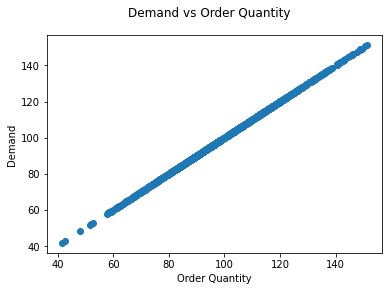

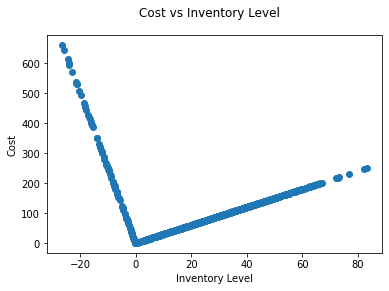

In [4]:
# Create an inventory simulation object, as well as the first node
myInvSim = InvSimulation()

# Node creation:  Key (mandatory), holding cost, stockout cost, and fixed order cost
myInvSim.createNode("retailer", 3, 25, 1000)

# Currently assume that everyone plays with the same plicy
myInvSim.playSimulation()

# You can get the cost record by accessing it directly from the inventory simulation
costRecord = myInvSim.costRecord
demandRecord = myInvSim.demandRecord
orderQtyRecord = myInvSim.orderQtyRecord
invLevelRecord = myInvSim.invLevelRecord

print("Optimal base stock is " + str(round(myInvSim.nodeDict['retailer'].baseStockLevel, 2)) + " for retailer")

# Remove the last entries from the returned arrays (we never order in response to the last demand incurred)
costRecord = costRecord[:-1, :]
demandRecord = demandRecord[:-1, :]
orderQtyRecord = orderQtyRecord[:-1, :]
invLevelRecord = invLevelRecord[:-1, :]

fig = plt.figure()
plt.scatter(orderQtyRecord, demandRecord)
fig.suptitle('Demand vs Order Quantity')
plt.xlabel('Order Quantity')
plt.ylabel('Demand')
plt.show()

fig = plt.figure()
plt.scatter(invLevelRecord, costRecord)
fig.suptitle('Cost vs Inventory Level')
plt.xlabel('Inventory Level')
plt.ylabel('Cost')
plt.show()

##Base Stock Variation Game Demo

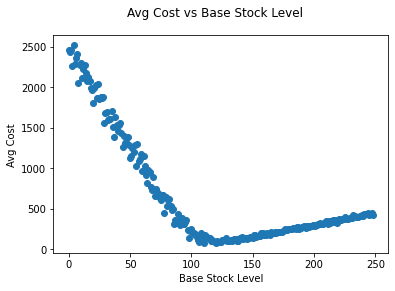

In [ ]:
# Create an inventory simulation object, as well as the first node
myInvSim = InvSimulation()

myInvSim.periodsToSimulate = 30

# Node creation:  Key (mandatory), holding cost, stockout cost, and fixed order cost
myInvSim.createNode("retailer", 3, 25, 1000)

# Currently assume that everyone plays with the same plicy
myInvSim.playSimulation("baseStockVariation", minBaseStockLevel=0, maxBaseStockLevel=250)

avgCostRecord = myInvSim.avgCostRecord
baseStockLevelRecord = myInvSim.baseStockLevelRecord

avgCostRecord = avgCostRecord[:-1, :]
baseStockLevelRecord = baseStockLevelRecord[:-1, :]

fig = plt.figure()
plt.scatter(baseStockLevelRecord, avgCostRecord)
fig.suptitle('Avg Cost vs Base Stock Level')
plt.xlabel('Base Stock Level')
plt.ylabel('Avg Cost')
plt.show()

> OLD CODE:  Procedural version of code implementation



In [ ]:
# Params:  Holding cost, stockout cost, and fixed order cost
h = 3
p = 25
K = 1000 

# Demand distribution statistics (assuming normality)
demandMean = 100
demandStDev = 20

periodsToSimulate = 1000


# No need to adjust - this is how we calculate critical fractile
criticalFractile = p / (p + h)

# Hold a record for each period
periodInfo = {}

# Initialize a demand for the first period, and calculate the correct value of S for a normal demand
thisPeriodDemand = np.random.normal(loc=demandMean, scale=demandStDev)
S = norm.ppf(criticalFractile, loc=demandMean, scale=demandStDev)

In [ ]:
# Iterate through each period of the inventory simulation game

for i in range(0,periodsToSimulate):
  if i == 0:
    startingInv = S
  else:
    startingInv = endingInv
  orderQty = max(0, S - startingInv)
  thisPeriodDemand = np.random.normal(loc=demandMean, scale=demandStDev)
  endingInv = startingInv + orderQty - thisPeriodDemand
  cost = h*max(0,endingInv)+p*max(0,-1*endingInv)
  periodInfo[i] = [startingInv,endingInv,orderQty,thisPeriodDemand,cost]